In [6]:
import os
if os.getcwd().split('/')[-1] != 'deepARTransit':
    os.chdir('../..')
import sys
import numpy as np
import matplotlib.pylab as plt
from pixlc import plotting
plt.rcParams['figure.figsize'] = (16, 6)

In [32]:
from utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator

experiment_folder = os.path.join('cobweb', 'deepartrans_fulltime')
#experiment_folder = os.path.join('cobweb', 'rlc/deeparsys_nocov')
#experiment_folder = os.path.join('cobweb', 'rlc/deeparsys_cent')
experiment_dir = os.path.join('deepartransit', 'experiments', experiment_folder)
config_file = get_config_file(experiment_dir)
config = process_config(config_file)
data = data_generator.DataGenerator(config)
width = int(np.sqrt(data.Z.shape[0]))

(25, 690, 1) (25, 690, 2)


In [33]:
traces_array = np.load(os.path.join(config.output_dir, 'pred_array.npy'))

In [34]:
pred_instr = traces_array.mean(axis=(0))
length_pred = pred_instr.shape[1]
plc_trans = data.Z[:, config.pretrans_length:config.pretrans_length+config.trans_length+1]

In [35]:
traces_array[:,0,:,0].shape

(100, 281)

## NN prediction = interpolation traces 

GridSpec(1, 1)

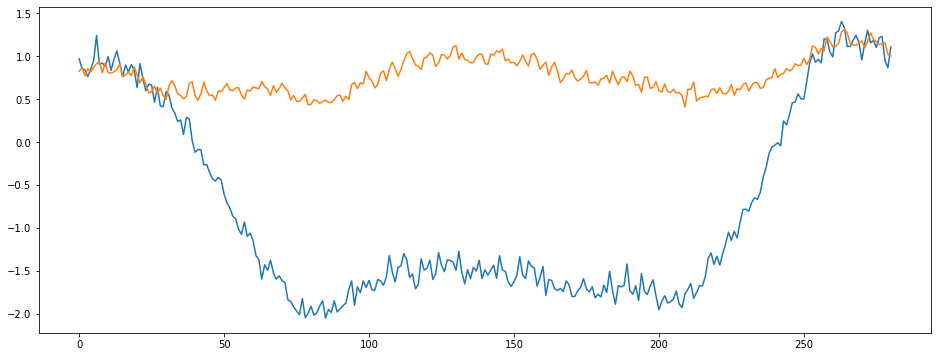

In [21]:
grid = plotting.plot_mozaic(plc_trans.T.reshape(-1, width, width))
plotting.plot_mozaic(pred_instr.T.reshape(-1, width, width), grid=grid)

## Back to Original units

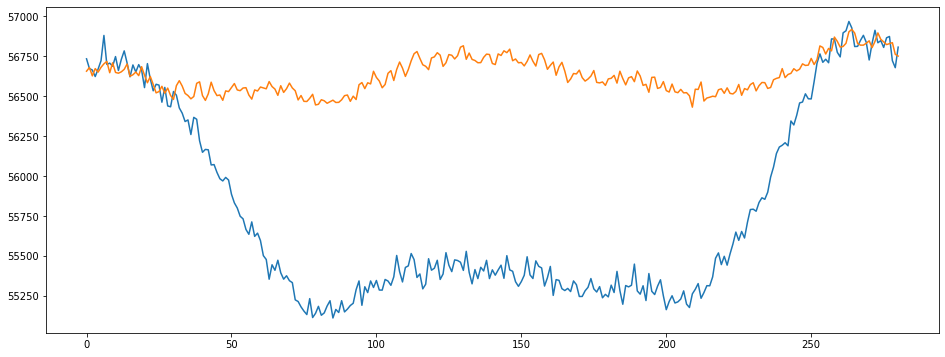

In [22]:
# Back to original scales
plc_trans = data.scaler_Z.inverse_transform(plc_trans)
pred_instr = data.scaler_Z.inverse_transform(pred_instr)
grid = plotting.plot_mozaic(plc_trans.T.reshape(-1, width, width), grid=grid)
grid = plotting.plot_mozaic(pred_instr.T.reshape(-1, width, width), grid=grid)


## Extracting the transit Component

GridSpec(1, 1)

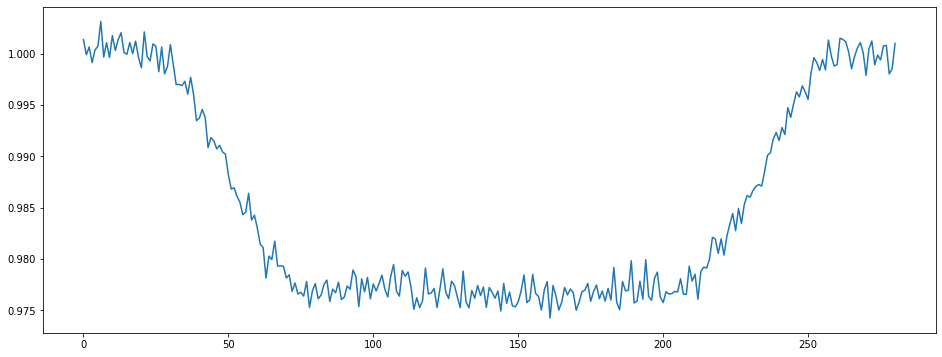

In [23]:
transit_component = (plc_trans/pred_instr)
plotting.plot_mozaic(transit_component.T.reshape(-1, width, width))


## Fitting a linear Transit to the transit component

In [24]:
import scipy.optimize as opt
from utils.transit import transit_linear
time_array = np.linspace(0., 1., length_pred)
popt, pcov = opt.curve_fit(transit_linear, 
                          np.expand_dims(time_array, 0).repeat(width**2, 0).flatten(), 
                          transit_component[:,:,0].flatten(), 
                          p0=(0.5, 0.1, 0.5, 0.05),
                          bounds= ((0.,0.,0.,0.), (1.,0.5, 1., 0.5)),
                          maxfev=100000)
print(popt)
print(pcov)

[0.50616727 0.02314133 0.65430263 0.15543064]
[[ 6.40098635e-07  4.16280528e-17 -1.46870997e-08 -4.09220194e-09]
 [ 4.16280529e-17  8.81622502e-09 -5.92148949e-08  5.92149007e-08]
 [-1.46870997e-08 -5.92148949e-08  2.95846140e-06 -4.49883620e-07]
 [-4.09220194e-09  5.92149007e-08 -4.49883620e-07  8.08615049e-06]]


GridSpec(1, 1)

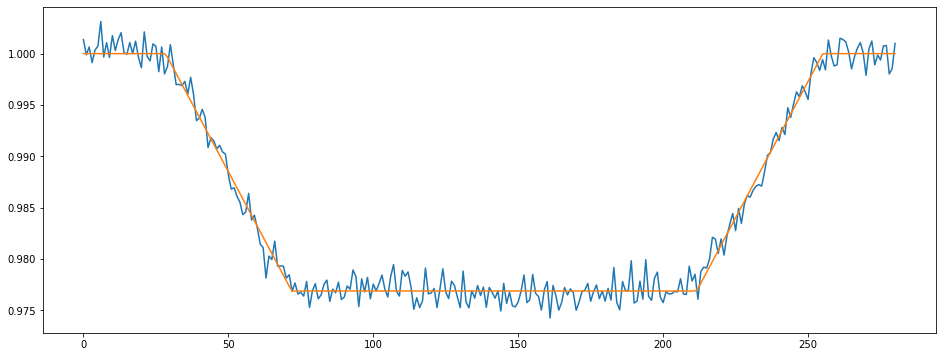

In [25]:
grid = plotting.plot_mozaic(transit_component.T.reshape(-1, width, width))
plotting.plot_mozaic(np.expand_dims(transit_linear(time_array, *popt), -1).repeat(width**2, -1).reshape(-1,width, width), 
                     grid=grid)


In [26]:
## Back to the instrument & 

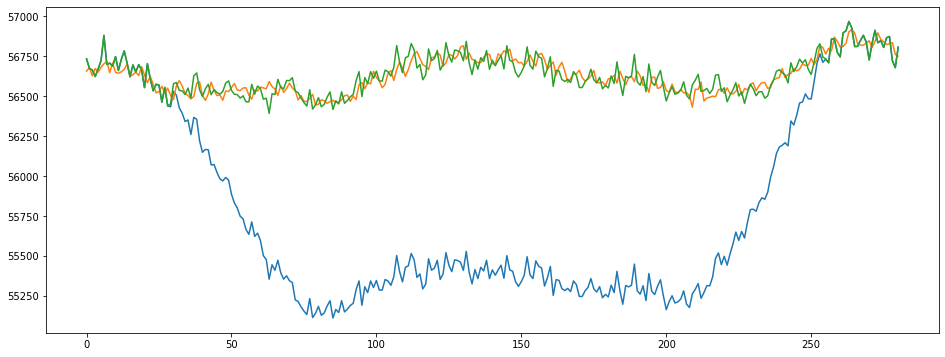

In [27]:
plt.plot(plc_trans.sum(0))
plt.plot(pred_instr.sum(0))
plt.plot(plc_trans.sum((0, -1))/transit_linear(time_array, *popt))